# Series Temporales

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de la ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.


Necesitamos Contestar a las siguientes preguntas: 


¿Cuál es el tensor de la serie temporal?
¿Cuál es la tendencia?
¿Es estacionaria?
¿Existe variabilidad o presencia de ruido?

In [1]:
# Your code here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pickle import dump

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
data.shape

(366, 2)

In [4]:
data.isna().sum()

date     0
sales    0
dtype: int64

In [5]:
data.dtypes

date      object
sales    float64
dtype: object

La variable de tiempo "Date" es un objeto y debemos pasarla a objeto temporal. 

Usamos to_datetime:

In [6]:
data['date'] = pd.to_datetime(data['date']).dt.date
data.head()


,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [7]:
data.tail()

,date,sales
361,2023-08-30,989.600354
362,2023-08-31,994.987326
363,2023-09-01,995.814415
364,2023-09-02,997.350214
365,2023-09-03,1000.482785


In [8]:
data.dtypes

date      object
sales    float64
dtype: object

In [9]:
data.date = pd.to_datetime(data.date)
data.head()

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [10]:
data.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [11]:
print(f"La fecha más antigua de la Serie es {data.date.min()}")
print(f"La fecha más reciente de la Serie es {data.date.max()}")

La fecha más antigua de la Serie es 2022-09-03 00:00:00
La fecha más reciente de la Serie es 2023-09-03 00:00:00


In [12]:
print(f"Días que transcurren en el intervalo de fechas: {(data.date. max() - data.date.min()).days}")
print(f"Valores únicos de fechas: {len(set(data.date))}")

Días que transcurren en el intervalo de fechas: 365
Valores únicos de fechas: 366


In [13]:
data.date.duplicated().sum()

0

Como el data set no contiene valores de fechas repetidos y el intervalo entre el min y el max es de 365 como tamién lo son los valores únicos de fecha, podemos estar seguros de que no hay valores de fecha descubiertos y que para todo los valores de sales tenemos un valor de fecha distinto. 

In [14]:
data.sales.describe()

count     366.000000
mean      524.963968
std       275.089698
min        53.803211
25%       290.186822
50%       520.699468
75%       763.289263
max      1000.482785
Name: sales, dtype: float64

In [15]:
#Pasamos la fecha como tal a ser el índice del DF y nombro una varible de la columna Sales como ts para mayor facilidad

data = data.set_index("date")  
ts = data["sales"]
data.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


In [16]:
data.tail()

,sales
date,
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415
2023-09-02,997.350214
2023-09-03,1000.482785


Gráfico de la evolución temporal de las ventas

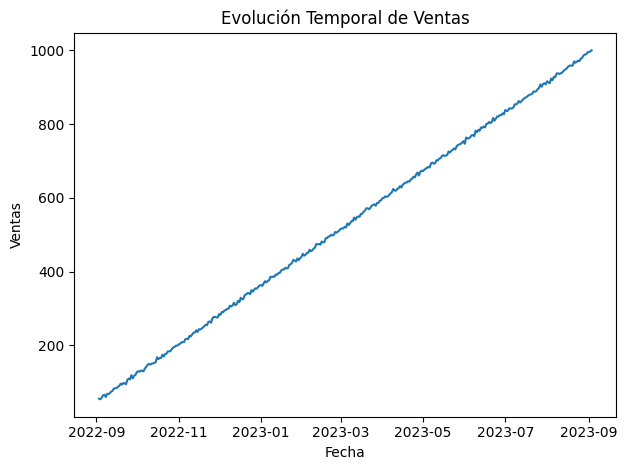

In [17]:
sns.lineplot(data = ts)
plt.title("Evolución Temporal de Ventas")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.tight_layout()
plt.show()

En un análisis visual breve, podemos notar que las ventas tienen una marcada tendencia positiva a lo largo del tiempo y presenta escasa variabilidad y sin puntos de inflexión. 

De todos modos, realizaremos una descomposición de la serie para análizar de una forma más exacta las características de las ventas a lo largo del tiempo. 



# Descomposición de la Serie

In [18]:
#Utilizaremos Seasonal_Decompose de StatsModel 
# Al tener datos diarios y como quiero evaluar un período estacional de meses, defino el period=30 como aproximación a un período mensual. 

decomp = seasonal_decompose(ts, period=30)
decomp

Tendencia| 
-----------------------

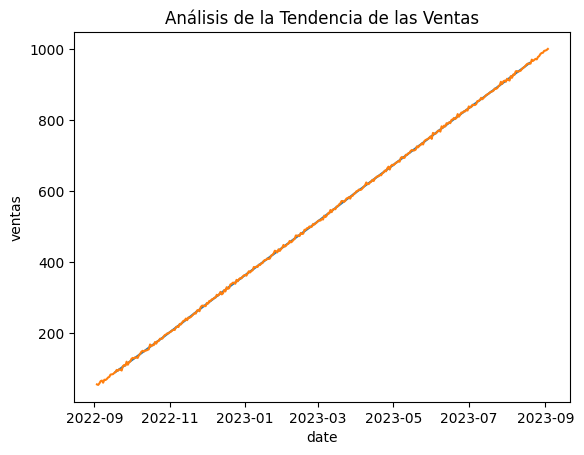

In [19]:
tendencia = decomp.trend

sns.lineplot(tendencia)
sns.lineplot(ts)
plt.ylabel('ventas')
plt.title('Análisis de la Tendencia de las Ventas')
plt.tight_layout
plt.show()


El gráfico devuelve una tendencia positiva a lo largo de los meses.

Estacionalidad| 
-----------------------

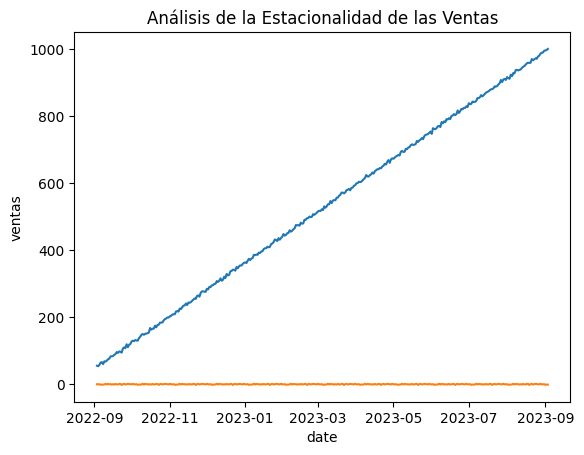

In [20]:
estacionalidad = decomp.seasonal

sns.lineplot(ts)
sns.lineplot(estacionalidad)

plt.ylabel('ventas')
plt.title('Análisis de la Estacionalidad de las Ventas')
plt.tight_layout
plt.show()



Prueba de Dickey-Fuller 


𝐻0: La serie temporal tiene raíz unitaria (es no estacionaria).

𝐻1 : La serie temporal no tiene raíz unitaria (es estacionaria).

In [21]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Un valor p alto sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad. En este caso, el valor p es 0.986190, lo que indica que no hay suficiente evidencia para rechazar la hipótesis nula.

El estadístico de prueba no es significativamente menor que los valores críticos, no tendríamos suficiente evidencia para rechazar la hipótesis nula y concluiríamos que la serie no es estacionaria.

Conlusión: No tenemos suficiente evidencia para rechazar la hipótesis nula, por lo que consideraremos la serie como no estacionaria.

Variabilidad| 
-----------------------

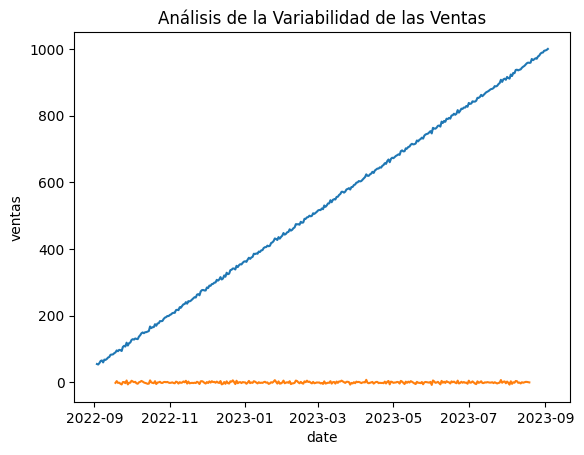

In [22]:
variabilidad = decomp.resid
sns.lineplot(ts)
sns.lineplot(variabilidad)

plt.ylabel('ventas')
plt.title('Análisis de la Variabilidad de las Ventas')
plt.tight_layout
plt.show()

Autocorrelación| 
-----------------------

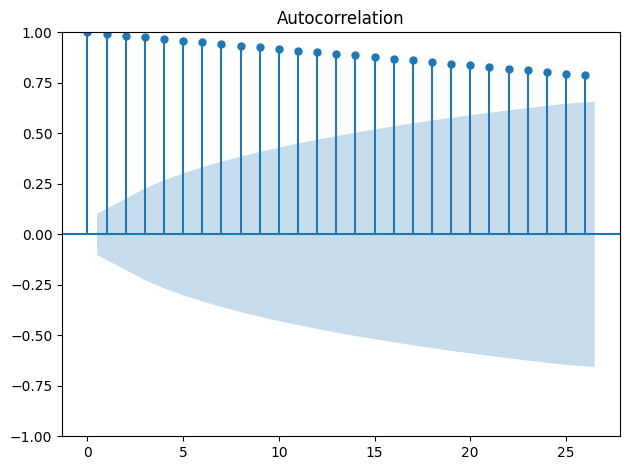

In [23]:
# Ploteamos el análisis de autocorrelación:
plot_acf(ts)
plt.tight_layout()
plt.show()

Se muestra una autocorrelación que disminuye a medida que aumenta el retraso en el eje x, pero las autocorrelaciones siguen siendo significativas. 


Interpretaciones posibles:

 - Persistencia en el tiempo: La disminución gradual de la autocorrelación sugiere que hay una dependencia en el tiempo en tus datos. Esto indica que los valores en un tiempo están correlacionados con los valores en tiempos anteriores, aunque esta correlación disminuye a medida que aumenta el retraso.


 - Memoria a corto plazo: Si las autocorrelaciones siguen siendo significativas incluso para retrasos relativamente largos, esto sugiere que hay una memoria a corto plazo en tus datos. En otras palabras, los valores en un tiempo están influenciados por los valores en tiempos recientes.


# Modelización

In [24]:
#Tras los resultados del análisis de descomposición, concluimos en que la Serie es No Estacionaria. 
# Por este motivo, debemos trabsformarla para poder utilizar el modelo ARIMA.

ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [25]:
# Utilizaremos un Modelo ARIMA
# La función hace una búsqueda en el espacio de soluciones posible para estimar los mejores parámetros

model_arima = auto_arima(ts_stationary, seasonal = True, trace = True, m = 30)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1845.252, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1843.274, Time=3.63 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=1843.049, Time=0.44 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=1843.220, Time=3.06 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=1843.587, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=1841.533, Time=0.38 sec
 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC=1841.467, Time=4.07 sec
 ARIMA(2,0,1)(2,0,0)[30] intercept   : AIC=1843.495, Time=16.85 sec
 ARIMA(2,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=1841.425, Time=3.28 sec
 ARIMA(2,0,1)(0,0,2)[30] int

In [26]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 30)   Log Likelihood                -914.720
Date:                            Sun, 21 Apr 2024   AIC                           1839.439
Time:                                    11:14:11   BIC                           1858.939
Sample:                                09-04-2022   HQIC                          1847.188
                                     - 09-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8192      0.134     20.986      0.000       2.556       3.083
ar.L1         -0.0850      0.052     -1.641      0.101      -0.187       0.016
ma.L1         -0.9435      0.020    -47.190      0.000      -0.983      -0.904
ma.S.L30      -0.0806      0.061     -1.323      0.186      -0.200       0.039
sigma2         8.7304      0.683     12.788      0.000       7.392      10.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               0.92   Skew:                             0.07
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Este modelo SARIMAX captura tanto la estructura temporal no estacional como la estacionalidad en los datos. El término (1, 0, 1) indica los órdenes de los términos ARIMA, mientras que el término (0, 0, 1, 30) especifica los órdenes y la periodicidad del componente estacional.



In [29]:
#predicción a 30 unidades de tiempo (dias = 1 mes)
predict = model_arima.predict(30)
predict

2023-09-04    2.046149
2023-09-05    2.162499
2023-09-06    2.827505
2023-09-07    2.042483
2023-09-08    2.743390
2023-09-09    2.940540
2023-09-10    2.700119
2023-09-11    2.713957
2023-09-12    2.406173
2023-09-13    2.549262
2023-09-14    2.623742
2023-09-15    2.473212
2023-09-16    2.492436
2023-09-17    2.652892
2023-09-18    2.882323
2023-09-19    2.762238
2023-09-20    1.895069
2023-09-21    3.122267
2023-09-22    2.592938
2023-09-23    2.547498
2023-09-24    2.915993
2023-09-25    2.220297
2023-09-26    2.657565
2023-09-27    2.298700
2023-09-28    2.585472
2023-09-29    2.799282
2023-09-30    2.337586
2023-10-01    2.780178
2023-10-02    2.710634
2023-10-03    2.493399
Freq: D, dtype: float64

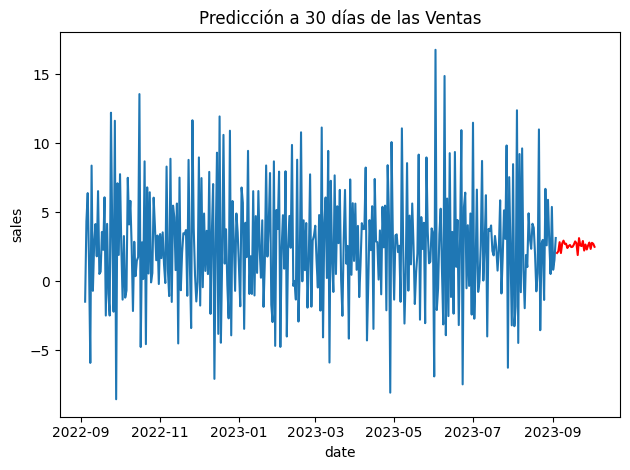

In [30]:
#Graficamos la predicción
plt.title("Predicción a 30 días de las Ventas")
sns.lineplot(data = ts_stationary)
sns.lineplot(data = predict, c = "red")
plt.tight_layout()
plt.show()